# FGD

Notebook investigating The 4D FGD LUT and various resampling schemes.

In [4]:
import struct
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm 
from matplotlib.colors import ListedColormap
from PIL import Image
from scipy.signal import decimate

def load_lut_from_file(path: str, dim: int) -> np.ndarray:
    with open(path, 'rb') as lut:
        
        
        size = [int.from_bytes(lut.read(4), 'little') for x in range(dim)]
        minmax = [(struct.unpack('f', lut.read(4))[0], struct.unpack('f', lut.read(4))[0]) for x in range(dim)]
        
        buffer = lut.read()


        print(size)
        print(minmax)

        flatarray = np.frombuffer(buffer, dtype=np.float32)
        flatarray = np.reshape(flatarray, size)

        return flatarray


FGD = load_lut_from_file("tm_FGD.bin", 4)

FGD = FGD.astype(np.float32)

FGD = np.swapaxes(FGD, 0,3)
FGD = np.swapaxes(FGD, 1,2)
FGD.tofile("tm_FGDnumpy.bin")


with open("tm_FGD_validate.bin", 'wb') as originalbin:
    [originalbin.write(int(x).to_bytes(4, 'little')) for x in FGD.shape]
    originalbin.write(struct.pack("f", 0.0))
    originalbin.write(struct.pack("f", 1.0))
    originalbin.write(struct.pack("f", 0.0))
    originalbin.write(struct.pack("f",1.0))
    originalbin.write(struct.pack("f",0.0))
    originalbin.write(struct.pack("f",4.0))
    originalbin.write(struct.pack("f",0.0))
    originalbin.write(struct.pack("f",4.0))
    originalbin.write((FGD.flatten('F').tobytes('C')))

#FGD_resample = FGD.reshape((*FGD.shape[:3], FGD.shape[3]//2, 2))

#FGD_resample_mean = np.mean(FGD_resample, axis=(4,))

FGD_resample_mean = decimate(FGD, 2, ftype='fir', axis=3)

print(FGD_resample_mean.shape)


newFGD = FGD_resample_mean.reshape((*FGD_resample_mean.shape[:2], FGD_resample_mean.shape[2] * FGD_resample_mean.shape[3]))

outFGD = newFGD
print(newFGD.dtype)


print(newFGD.shape)


with open("tm_FGD_resample.bin", 'wb') as fbin:
    [fbin.write(int(x).to_bytes(4, 'little')) for x in outFGD.shape]
    #mins and maxes
    fbin.write(struct.pack("f", 0.0))
    fbin.write(struct.pack("f", 1.0))
    fbin.write(struct.pack("f", 0.0))
    fbin.write(struct.pack("f",1.0))
    fbin.write(struct.pack("f",0.0))
    fbin.write(struct.pack("f",4.0))
    fbin.write((outFGD.flatten('F')).tobytes('C')) #write bytes

[64, 64, 64, 64]
[(0.0, 1.0), (0.0, 1.0), (0.0, 4.0), (0.0, 4.0)]
(64, 64, 64, 32)
float32
(64, 64, 2048)


/tmp/ipykernel_6811/1090879989.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gist_heat = cm.get_cmap('gist_heat', len(newFGD))


(64, 64)
0.19269407
0.0016507553
0.20014732
0.003696531


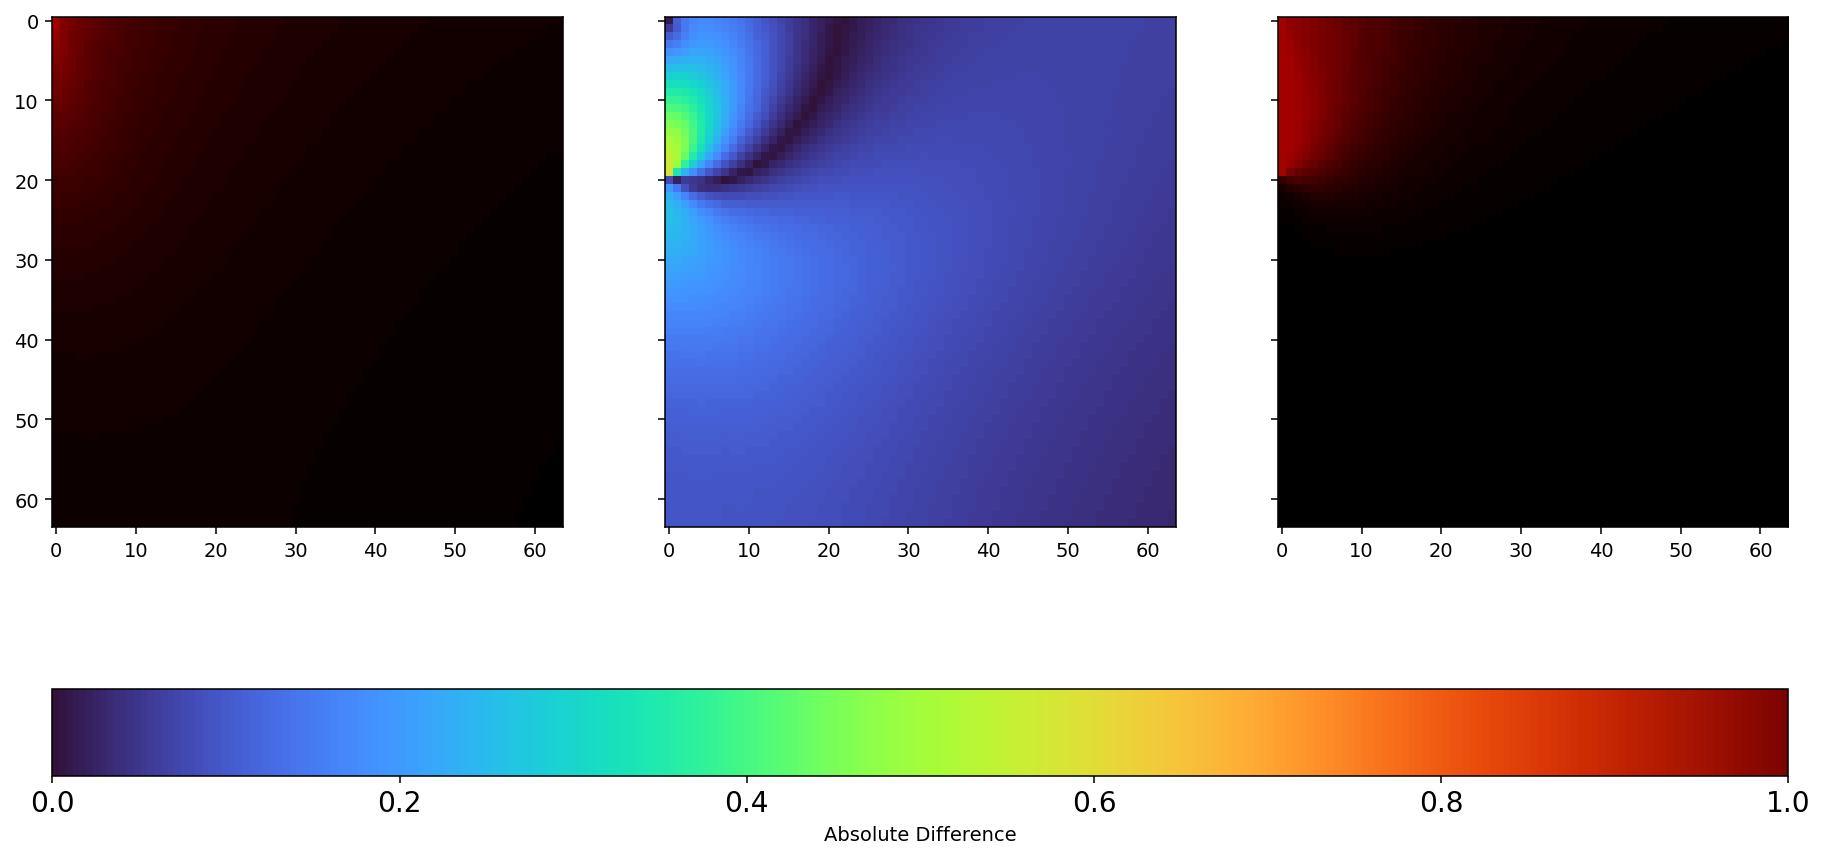

In [20]:
fig = plt.figure(1, dpi=140, figsize=(16,10))
axes = fig.subplots(1,3,sharex=True, sharey=True)

gist_heat = cm.get_cmap('gist_heat', len(newFGD))
newColors= gist_heat(range(28))[:round(len(newFGD)/2)]
newCmap = ListedColormap(newColors)

print(outFGD[:,:,0].shape)

resampledSlice = outFGD[:,:,485]
FGDSlice = FGD[:,:,15,0]

delta = np.abs(resampledSlice - FGDSlice)

axes[0].imshow(resampledSlice, vmin=0.0, vmax=1.0, cmap=newCmap, origin='upper')
axes[2].imshow(FGDSlice, vmin =0.0, vmax=1.0, cmap=newCmap, origin='upper')
diffplot = axes[1].imshow(delta, vmin=0.0, vmax=1.0, cmap='turbo', origin='upper')


col = fig.colorbar(diffplot, ax=axes, orientation='horizontal', )
col.set_label(label="Absolute Difference",)
col.ax.tick_params(labelsize='x-large')

print(FGD[63, 0, 15, 15])
print(FGD[63,0, 15, 1])

#outFGDtest = outFGD.reshape(64, 64, 2048)

print(outFGD[63,0, 513+7])
print(outFGD[63,0,513])


Average Absolute Error 0.006935233
Mean Squared Error: 0.00012226016212557825


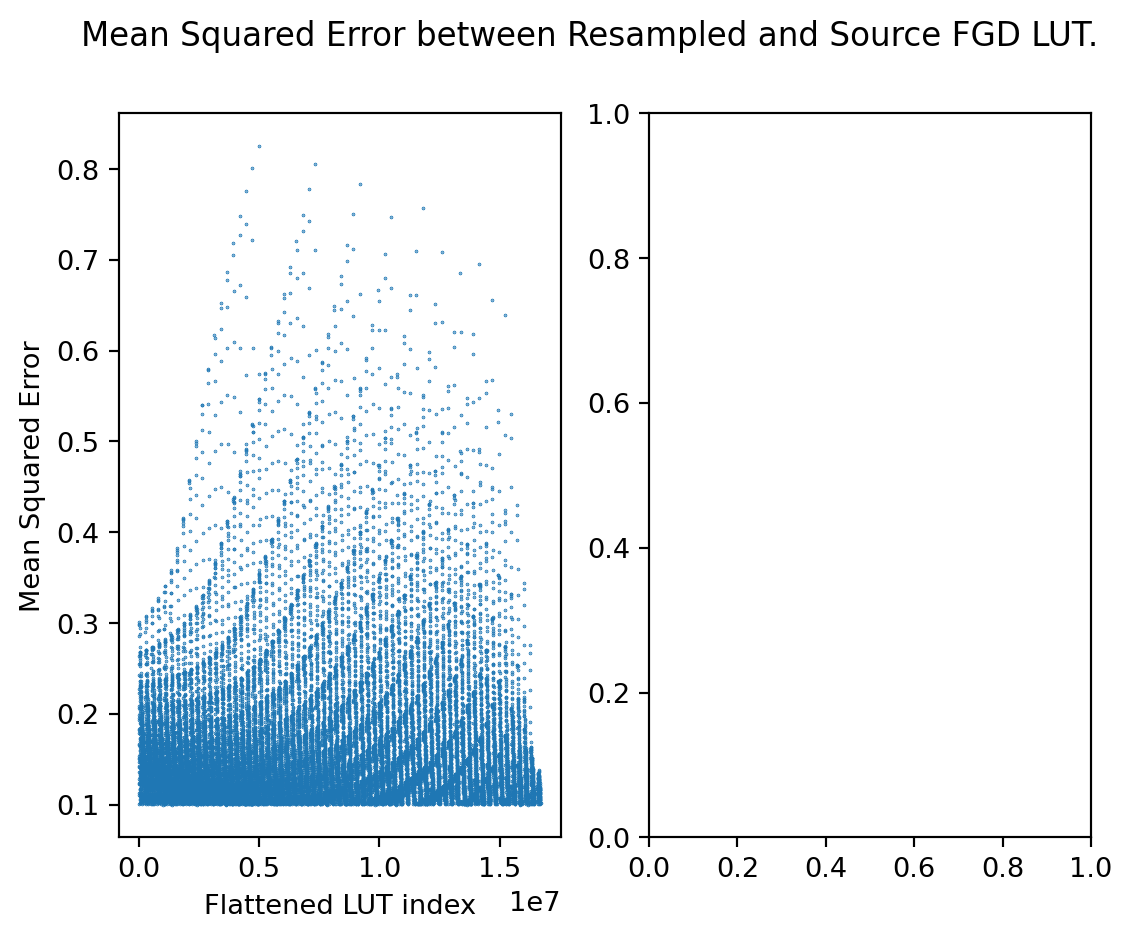

In [5]:
resample_up = FGD_resample_mean.repeat(2, axis=3)

MSE = ((resample_up - FGD)**2).mean(axis=3, dtype=np.float64)
AbsoluteError = np.abs(FGD - resample_up)
print("Average Absolute Error", np.mean(AbsoluteError)) 
print("Mean Squared Error:", np.mean(MSE, dtype=np.float64))


MSEfig = plt.figure(1, dpi=196)
MSEfig.suptitle("Mean Squared Error between Resampled and Source FGD LUT.")
ax = MSEfig.subplots(1,2)
ax[0].set_xlabel("Flattened LUT index")
ax[0].set_ylabel("Mean Squared Error")

EPSILON = 0.1
AbsSignificant = np.copy(AbsoluteError[:,:,:,:]) 
AbsSignificantClipped = np.copy(AbsSignificant)

AbsSignificantClipped[AbsSignificantClipped < EPSILON] = np.nan
AbsSignificantFlat = AbsSignificantClipped.flatten()

MSEFlat = (MSE[:,:,:16]).flatten()
AbsFlat = (AbsoluteError[:,:,:,:]).flatten()

MSEplot = ax[0].scatter(np.arange(AbsSignificantFlat.shape[0]), AbsSignificantFlat, s=0.1)
#ax[1].imshow(AbsSignificant, cmap='turbo', vmin=0, vmax=1)

#ax[1].plot(np.arange(AbsFlat.shape[0]), AbsFlat)

#linegraph = plt.plot(np.linspace(0, 64*64*64*32, 64*64*64*32), FGD_resample_mean.flatten(), marker=".")
#plt.plot(np.linspace(0, 64*64*64*64, 64*64*64*64), FGD.flatten(), marker='.')